In this notebook, an Automed Valuation Model for prediction of house prices.

Initially, database was enriched by information provided from OpenStreetMap (which among others informed about, road, county). Next, the sold price (target feature) was processed to remove outliers by application of IQR as criteria for outlier detection. Then four pipelines are joined to composed feature preprocessing step: 

i) **numerical pipeline** replaces missing values replaced by median and scale of numerical features. 

ii) **categorical pipeline** replaces missing values by most frequent and applies one hot encode on non-numeric features. 

iii) **text pipeline** process postal_address through vectorization in a bag-of-words approch.

iv) **date pipeline** extracts temporal information from feature sold date such as year, day of week. 

Finally, the resultant feature preprocessing pipeline serve as input for a tree gradient boosting model which is trained to predict house prices. The last step used for improving model performance is the **hyperparameter optimization** based on bayesian search which search for the best set of hyperparameters.


#### Import Libraries

In [23]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from metrics import get_MdPE, get_MdAPE, get_PPE, scorer_get_PPE
from utils import (
    TextSelector, NumberWords, Tokenizer, DateProcess, 
    QuantizeCat, remove_outliers_iqr_label
)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 1000)

#### Read dataset (split train test)

In [14]:
df = pd.read_csv('new_dataset.csv')
X = df.drop(columns=['id', 'sold_price'])
y = df['sold_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Deal with outliers in label

In [15]:
y_train = remove_outliers_iqr_label(y_train)

#### Define pipeline for numerical features

In [16]:
num_features = ['sqm_value', 'yoc_value', 'storey_value', 'beds_value', 'new_home_ind']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#### Define pipeline for categorical features

In [17]:
cat_features = ['thoroughfare_id', 'census2016_small_area_geogid',
                'eircode_area_code','post_county_name', 
                'building_property_subtype_code', 
                'road', 'city_district', 'city', 'district', 
                'state_district', 'postcode']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
    ])

#### Compose feature preprocessing pipelines and add text pipeline

In [18]:
from nltk.corpus import stopwords 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
    
stop_words = list(stopwords.words('english'))

pipe = Pipeline([
    ('features', FeatureUnion([
        ('dateproc', Pipeline([
            ('dateprocess', DateProcess('sold_date')),
            ('dscaler', StandardScaler()),
        ])),
#         ('text', Pipeline([
#            ('colext', TextSelector('postal_address')),
#            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, stop_words=stop_words,              
#                                       min_df=.0025, max_df=0.5, ngram_range=(1,4))),
#            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
#         ])),
        ('ngram',  Pipeline([
            ('colext2', TextSelector('postal_address')),
            ('Ngram', CountVectorizer(ngram_range=(1, 4), analyzer='char')),
            ])),
#         ('words', Pipeline([
#             ('wordext', NumberWords('postal_address')),
#             ('wscaler', StandardScaler()),
#         ])),
        ('additional', ColumnTransformer(
            transformers=[
                ('cat', categorical_transformer, cat_features),
                ('num', numeric_transformer, num_features),
            ])),
        
    ]))
])

#### Train regression model 

In [19]:
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'sub_feature': 0.5,
    'num_leaves': 31,
}


clf = Pipeline(steps=[('preprocessor', pipe),
                      ('regressor', LGBMRegressor(**params)),
                      ])  
clf.fit(X_train,y_train);

#### Test dataset prediction

In [20]:
pred = clf.predict(X_test)

#### Check model performance

In [21]:
print(f'MdPE: {100*round(get_MdPE(pred, y_test),2)}% -- between +/- 3%')
print(f'MAdPE: {100*round(get_MdAPE(pred, y_test),2)}% -- less than 10%')
print(f'PPE10: {100*round(get_PPE(pred, y_test, 0.1),2)}% -- 70% or greater')
print(f'PPE20: {100*round(get_PPE(pred, y_test, 0.2),2)}% -- 85% or greater')

MdPE: -1.0% -- between +/- 3%
MAdPE: 16.0% -- less than 10%
PPE10: 32.0% -- 70% or greater
PPE20: 59.0% -- 85% or greater


#### Model Feature Importance

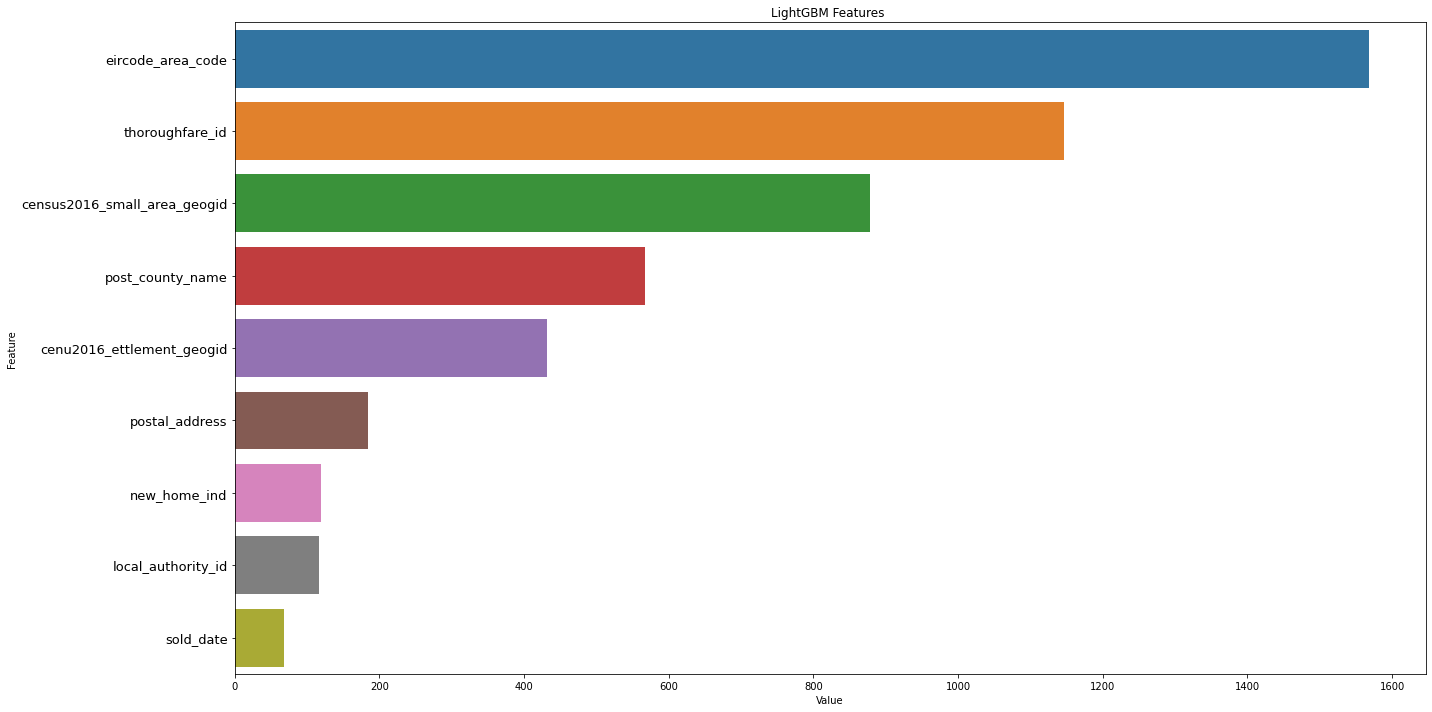

In [34]:
feature_imp = pd.DataFrame(sorted(zip(clf['regressor'].feature_importances_,X.columns)), columns=['Value','Feature'])
feature_imp= feature_imp[feature_imp['Value']>40]
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features ', fontsize=12)
ax.tick_params(axis='y', which='major', labelsize=13)
plt.tight_layout()
plt.show()

#### Hyperparameters optimization: Baysian strategy

Optimization based on PPE20 metric.

##### Cost Function

In [10]:
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt.pyll import scope
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score


kf = KFold(n_splits=10, random_state=42)
def obj_function(params, random_state=42, cv=kf, X=X_train, y=y_train):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'learning_rate': params['learning_rate'],
        'num_leaves': int(params['num_leaves']),
        'subsample_for_bin': int(params['subsample_for_bin']), 
        'min_child_samples': int(params['min_child_samples']),
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
    }
    
    pipe.fit(X)
    X = pipe.transform(X)
    

    model = LGBMRegressor(random_state=random_state, **params)    
    my_scorer = make_scorer(scorer_get_PPE, greater_is_better=True)
    score = -cross_val_score(model, X, y, cv=cv, scoring=my_scorer, n_jobs=-1).mean()

    return score

##### Searching procedure


In [11]:
%%time
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': scope.int(hp.quniform('subsample_for_bin', 20000, 300000, 20000)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 20, 500, 5)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}

trials = Trials()

best=fmin(fn=obj_function, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=200, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(42) # fixing random state for the reproducibility
         )
print(best)

100%|████████████████████████████████████████████████| 200/200 [45:50<00:00, 13.75s/it, best loss: -0.6359999999999999]
{'learning_rate': 0.026759502280541275, 'min_child_samples': 20.0, 'n_estimators': 535.0, 'num_leaves': 36.0, 'reg_alpha': 0.9558241401836571, 'reg_lambda': 0.19811889488104195, 'subsample_for_bin': 140000.0}
Wall time: 45min 50s
